In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""
fpi = 10

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


 - Min class count:  976
Loaded 2928 images
Dataset type test label type: species


 - Min class count:  976
Loaded 17568 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 of58uq12


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-of58uq12:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:3.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                          | 0/330 [00:00<?, ?it/s]

  0%|▎                                                                                                                 | 1/330 [00:01<07:35,  1.38s/it]

  1%|▋                                                                                                                 | 2/330 [00:01<03:49,  1.43it/s]

  1%|█                                                                                                                 | 3/330 [00:01<02:37,  2.08it/s]

  1%|█▍                                                                                                                | 4/330 [00:02<02:03,  2.65it/s]

  2%|█▋                                                                                                                | 5/330 [00:02<01:44,  3.11it/s]

  2%|██                                                                                                                | 6/330 [00:02<01:32,  3.49it/s]

  2%|██▍                                                                                                               | 7/330 [00:02<01:25,  3.77it/s]

  2%|██▊                                                                                                               | 8/330 [00:02<01:20,  3.99it/s]

  3%|███                                                                                                               | 9/330 [00:03<01:17,  4.15it/s]

  3%|███▍                                                                                                             | 10/330 [00:03<01:15,  4.26it/s]

  3%|███▊                                                                                                             | 11/330 [00:03<01:13,  4.34it/s]

  4%|████                                                                                                             | 12/330 [00:03<01:12,  4.40it/s]

  4%|████▍                                                                                                            | 13/330 [00:04<01:11,  4.44it/s]

  4%|████▊                                                                                                            | 14/330 [00:04<01:10,  4.47it/s]

  5%|█████▏                                                                                                           | 15/330 [00:04<01:10,  4.49it/s]

  5%|█████▍                                                                                                           | 16/330 [00:04<01:09,  4.51it/s]

  5%|█████▊                                                                                                           | 17/330 [00:04<01:09,  4.52it/s]

  5%|██████▏                                                                                                          | 18/330 [00:05<01:08,  4.53it/s]

  6%|██████▌                                                                                                          | 19/330 [00:05<01:08,  4.53it/s]

  6%|██████▊                                                                                                          | 20/330 [00:05<01:08,  4.53it/s]

  6%|███████▏                                                                                                         | 21/330 [00:05<01:08,  4.54it/s]

  7%|███████▌                                                                                                         | 22/330 [00:06<01:07,  4.54it/s]

  7%|███████▉                                                                                                         | 23/330 [00:06<01:07,  4.54it/s]

  7%|████████▏                                                                                                        | 24/330 [00:06<01:07,  4.54it/s]

  8%|████████▌                                                                                                        | 25/330 [00:06<01:07,  4.54it/s]

  8%|████████▉                                                                                                        | 26/330 [00:06<01:06,  4.54it/s]

  8%|█████████▏                                                                                                       | 27/330 [00:07<01:06,  4.54it/s]

  8%|█████████▌                                                                                                       | 28/330 [00:07<01:06,  4.54it/s]

  9%|█████████▉                                                                                                       | 29/330 [00:07<01:06,  4.54it/s]

  9%|██████████▎                                                                                                      | 30/330 [00:07<01:06,  4.54it/s]

  9%|██████████▌                                                                                                      | 31/330 [00:07<01:05,  4.54it/s]

 10%|██████████▉                                                                                                      | 32/330 [00:08<01:05,  4.54it/s]

 10%|███████████▎                                                                                                     | 33/330 [00:08<01:05,  4.54it/s]

 10%|███████████▋                                                                                                     | 34/330 [00:08<01:05,  4.54it/s]

 11%|███████████▉                                                                                                     | 35/330 [00:08<01:04,  4.54it/s]

 11%|████████████▎                                                                                                    | 36/330 [00:09<01:04,  4.54it/s]

 11%|████████████▋                                                                                                    | 37/330 [00:09<01:04,  4.54it/s]

 12%|█████████████                                                                                                    | 38/330 [00:09<01:04,  4.54it/s]

 12%|█████████████▎                                                                                                   | 39/330 [00:09<01:04,  4.54it/s]

 12%|█████████████▋                                                                                                   | 40/330 [00:09<01:03,  4.54it/s]

 12%|██████████████                                                                                                   | 41/330 [00:10<01:03,  4.54it/s]

 13%|██████████████▍                                                                                                  | 42/330 [00:10<01:03,  4.54it/s]

 13%|██████████████▋                                                                                                  | 43/330 [00:10<01:03,  4.54it/s]

 13%|███████████████                                                                                                  | 44/330 [00:10<01:02,  4.54it/s]

 14%|███████████████▍                                                                                                 | 45/330 [00:11<01:02,  4.54it/s]

 14%|███████████████▊                                                                                                 | 46/330 [00:11<01:02,  4.54it/s]

 14%|████████████████                                                                                                 | 47/330 [00:11<01:02,  4.54it/s]

 15%|████████████████▍                                                                                                | 48/330 [00:11<01:02,  4.54it/s]

 15%|████████████████▊                                                                                                | 49/330 [00:11<01:01,  4.54it/s]

 15%|█████████████████                                                                                                | 50/330 [00:12<01:01,  4.54it/s]

 15%|█████████████████▍                                                                                               | 51/330 [00:12<01:01,  4.54it/s]

 16%|█████████████████▊                                                                                               | 52/330 [00:12<01:01,  4.54it/s]

 16%|██████████████████▏                                                                                              | 53/330 [00:12<01:00,  4.54it/s]

 16%|██████████████████▍                                                                                              | 54/330 [00:13<01:00,  4.54it/s]

 17%|██████████████████▊                                                                                              | 55/330 [00:13<01:00,  4.54it/s]

 17%|███████████████████▏                                                                                             | 56/330 [00:13<01:00,  4.54it/s]

 17%|███████████████████▌                                                                                             | 57/330 [00:13<01:00,  4.54it/s]

 18%|███████████████████▊                                                                                             | 58/330 [00:13<00:59,  4.54it/s]

 18%|████████████████████▏                                                                                            | 59/330 [00:14<00:59,  4.54it/s]

 18%|████████████████████▌                                                                                            | 60/330 [00:14<00:59,  4.54it/s]

 18%|████████████████████▉                                                                                            | 61/330 [00:14<00:59,  4.54it/s]

 19%|█████████████████████▏                                                                                           | 62/330 [00:14<00:59,  4.54it/s]

 19%|█████████████████████▌                                                                                           | 63/330 [00:15<00:58,  4.54it/s]

 19%|█████████████████████▉                                                                                           | 64/330 [00:15<00:58,  4.54it/s]

 20%|██████████████████████▎                                                                                          | 65/330 [00:15<00:58,  4.54it/s]

 20%|██████████████████████▌                                                                                          | 66/330 [00:15<00:58,  4.54it/s]

 20%|██████████████████████▉                                                                                          | 67/330 [00:15<00:57,  4.54it/s]

 21%|███████████████████████▎                                                                                         | 68/330 [00:16<00:57,  4.54it/s]

 21%|███████████████████████▋                                                                                         | 69/330 [00:16<00:57,  4.54it/s]

 21%|███████████████████████▉                                                                                         | 70/330 [00:16<00:57,  4.54it/s]

 22%|████████████████████████▎                                                                                        | 71/330 [00:16<00:57,  4.54it/s]

 22%|████████████████████████▋                                                                                        | 72/330 [00:17<00:56,  4.54it/s]

 22%|████████████████████████▉                                                                                        | 73/330 [00:17<00:56,  4.54it/s]

 22%|█████████████████████████▎                                                                                       | 74/330 [00:17<00:56,  4.54it/s]

 23%|█████████████████████████▋                                                                                       | 75/330 [00:17<00:56,  4.54it/s]

 23%|██████████████████████████                                                                                       | 76/330 [00:17<00:55,  4.54it/s]

 23%|██████████████████████████▎                                                                                      | 77/330 [00:18<00:55,  4.54it/s]

 24%|██████████████████████████▋                                                                                      | 78/330 [00:18<00:55,  4.54it/s]

 24%|███████████████████████████                                                                                      | 79/330 [00:18<00:55,  4.54it/s]

 24%|███████████████████████████▍                                                                                     | 80/330 [00:18<00:55,  4.54it/s]

 25%|███████████████████████████▋                                                                                     | 81/330 [00:18<00:54,  4.54it/s]

 25%|████████████████████████████                                                                                     | 82/330 [00:19<00:54,  4.54it/s]

 25%|████████████████████████████▍                                                                                    | 83/330 [00:19<00:54,  4.54it/s]

 25%|████████████████████████████▊                                                                                    | 84/330 [00:19<00:54,  4.54it/s]

 26%|█████████████████████████████                                                                                    | 85/330 [00:19<00:53,  4.54it/s]

 26%|█████████████████████████████▍                                                                                   | 86/330 [00:20<00:53,  4.54it/s]

 26%|█████████████████████████████▊                                                                                   | 87/330 [00:20<00:53,  4.54it/s]

 27%|██████████████████████████████▏                                                                                  | 88/330 [00:20<00:53,  4.54it/s]

 27%|██████████████████████████████▍                                                                                  | 89/330 [00:20<00:53,  4.54it/s]

 27%|██████████████████████████████▊                                                                                  | 90/330 [00:20<00:52,  4.54it/s]

 28%|███████████████████████████████▏                                                                                 | 91/330 [00:21<00:52,  4.54it/s]

 28%|███████████████████████████████▌                                                                                 | 92/330 [00:21<00:52,  4.54it/s]

 28%|███████████████████████████████▊                                                                                 | 93/330 [00:21<00:52,  4.54it/s]

 28%|████████████████████████████████▏                                                                                | 94/330 [00:21<00:51,  4.54it/s]

 29%|████████████████████████████████▌                                                                                | 95/330 [00:22<00:51,  4.54it/s]

 29%|████████████████████████████████▊                                                                                | 96/330 [00:22<00:51,  4.54it/s]

 29%|█████████████████████████████████▏                                                                               | 97/330 [00:22<00:51,  4.54it/s]

 30%|█████████████████████████████████▌                                                                               | 98/330 [00:22<00:51,  4.54it/s]

 30%|█████████████████████████████████▉                                                                               | 99/330 [00:22<00:50,  4.54it/s]

 30%|█████████████████████████████████▉                                                                              | 100/330 [00:23<00:50,  4.54it/s]

 31%|██████████████████████████████████▎                                                                             | 101/330 [00:23<00:50,  4.54it/s]

 31%|██████████████████████████████████▌                                                                             | 102/330 [00:23<00:50,  4.54it/s]

 31%|██████████████████████████████████▉                                                                             | 103/330 [00:23<00:49,  4.54it/s]

 32%|███████████████████████████████████▎                                                                            | 104/330 [00:24<00:49,  4.54it/s]

 32%|███████████████████████████████████▋                                                                            | 105/330 [00:24<00:49,  4.54it/s]

 32%|███████████████████████████████████▉                                                                            | 106/330 [00:24<00:49,  4.54it/s]

 32%|████████████████████████████████████▎                                                                           | 107/330 [00:24<00:49,  4.54it/s]

 33%|████████████████████████████████████▋                                                                           | 108/330 [00:24<00:48,  4.54it/s]

 33%|████████████████████████████████████▉                                                                           | 109/330 [00:25<00:48,  4.54it/s]

 33%|█████████████████████████████████████▎                                                                          | 110/330 [00:25<00:48,  4.54it/s]

 34%|█████████████████████████████████████▋                                                                          | 111/330 [00:25<00:48,  4.54it/s]

 34%|██████████████████████████████████████                                                                          | 112/330 [00:25<00:48,  4.54it/s]

 34%|██████████████████████████████████████▎                                                                         | 113/330 [00:26<00:47,  4.54it/s]

 35%|██████████████████████████████████████▋                                                                         | 114/330 [00:26<00:47,  4.54it/s]

 35%|███████████████████████████████████████                                                                         | 115/330 [00:26<00:47,  4.54it/s]

 35%|███████████████████████████████████████▎                                                                        | 116/330 [00:26<00:47,  4.54it/s]

 35%|███████████████████████████████████████▋                                                                        | 117/330 [00:26<00:46,  4.54it/s]

 36%|████████████████████████████████████████                                                                        | 118/330 [00:27<00:46,  4.54it/s]

 36%|████████████████████████████████████████▍                                                                       | 119/330 [00:27<00:46,  4.54it/s]

 36%|████████████████████████████████████████▋                                                                       | 120/330 [00:27<00:46,  4.54it/s]

 37%|█████████████████████████████████████████                                                                       | 121/330 [00:27<00:46,  4.54it/s]

 37%|█████████████████████████████████████████▍                                                                      | 122/330 [00:28<00:45,  4.54it/s]

 37%|█████████████████████████████████████████▋                                                                      | 123/330 [00:28<00:45,  4.54it/s]

 38%|██████████████████████████████████████████                                                                      | 124/330 [00:28<00:45,  4.54it/s]

 38%|██████████████████████████████████████████▍                                                                     | 125/330 [00:28<00:45,  4.54it/s]

 38%|██████████████████████████████████████████▊                                                                     | 126/330 [00:28<00:44,  4.54it/s]

 38%|███████████████████████████████████████████                                                                     | 127/330 [00:29<00:44,  4.54it/s]

 39%|███████████████████████████████████████████▍                                                                    | 128/330 [00:29<00:44,  4.54it/s]

 39%|███████████████████████████████████████████▊                                                                    | 129/330 [00:29<00:44,  4.54it/s]

 39%|████████████████████████████████████████████                                                                    | 130/330 [00:29<00:44,  4.54it/s]

 40%|████████████████████████████████████████████▍                                                                   | 131/330 [00:30<00:43,  4.54it/s]

 40%|████████████████████████████████████████████▊                                                                   | 132/330 [00:30<00:43,  4.54it/s]

 40%|█████████████████████████████████████████████▏                                                                  | 133/330 [00:30<00:43,  4.54it/s]

 41%|█████████████████████████████████████████████▍                                                                  | 134/330 [00:30<00:43,  4.54it/s]

 41%|█████████████████████████████████████████████▊                                                                  | 135/330 [00:30<00:42,  4.54it/s]

 41%|██████████████████████████████████████████████▏                                                                 | 136/330 [00:31<00:42,  4.54it/s]

 42%|██████████████████████████████████████████████▍                                                                 | 137/330 [00:31<00:42,  4.54it/s]

 42%|██████████████████████████████████████████████▊                                                                 | 138/330 [00:31<00:42,  4.54it/s]

 42%|███████████████████████████████████████████████▏                                                                | 139/330 [00:31<00:42,  4.54it/s]

 42%|███████████████████████████████████████████████▌                                                                | 140/330 [00:31<00:41,  4.54it/s]

 43%|███████████████████████████████████████████████▊                                                                | 141/330 [00:32<00:41,  4.54it/s]

 43%|████████████████████████████████████████████████▏                                                               | 142/330 [00:32<00:41,  4.54it/s]

 43%|████████████████████████████████████████████████▌                                                               | 143/330 [00:32<00:41,  4.54it/s]

 44%|████████████████████████████████████████████████▊                                                               | 144/330 [00:32<00:41,  4.54it/s]

 44%|█████████████████████████████████████████████████▏                                                              | 145/330 [00:33<00:40,  4.54it/s]

 44%|█████████████████████████████████████████████████▌                                                              | 146/330 [00:33<00:40,  4.54it/s]

 45%|█████████████████████████████████████████████████▉                                                              | 147/330 [00:33<00:40,  4.54it/s]

 45%|██████████████████████████████████████████████████▏                                                             | 148/330 [00:33<00:40,  4.54it/s]

 45%|██████████████████████████████████████████████████▌                                                             | 149/330 [00:33<00:39,  4.54it/s]

 45%|██████████████████████████████████████████████████▉                                                             | 150/330 [00:34<00:39,  4.54it/s]

 46%|███████████████████████████████████████████████████▏                                                            | 151/330 [00:34<00:39,  4.54it/s]

 46%|███████████████████████████████████████████████████▌                                                            | 152/330 [00:34<00:39,  4.54it/s]

 46%|███████████████████████████████████████████████████▉                                                            | 153/330 [00:34<00:39,  4.54it/s]

 47%|████████████████████████████████████████████████████▎                                                           | 154/330 [00:35<00:38,  4.54it/s]

 47%|████████████████████████████████████████████████████▌                                                           | 155/330 [00:35<00:38,  4.54it/s]

 47%|████████████████████████████████████████████████████▉                                                           | 156/330 [00:35<00:38,  4.54it/s]

 48%|█████████████████████████████████████████████████████▎                                                          | 157/330 [00:35<00:38,  4.54it/s]

 48%|█████████████████████████████████████████████████████▌                                                          | 158/330 [00:35<00:37,  4.54it/s]

 48%|█████████████████████████████████████████████████████▉                                                          | 159/330 [00:36<00:37,  4.54it/s]

 48%|██████████████████████████████████████████████████████▎                                                         | 160/330 [00:36<00:37,  4.54it/s]

 49%|██████████████████████████████████████████████████████▋                                                         | 161/330 [00:36<00:37,  4.54it/s]

 49%|██████████████████████████████████████████████████████▉                                                         | 162/330 [00:36<00:37,  4.54it/s]

 49%|███████████████████████████████████████████████████████▎                                                        | 163/330 [00:37<00:36,  4.54it/s]

 50%|███████████████████████████████████████████████████████▋                                                        | 164/330 [00:37<00:36,  4.54it/s]

 50%|████████████████████████████████████████████████████████                                                        | 165/330 [00:37<00:36,  4.54it/s]

 50%|████████████████████████████████████████████████████████▎                                                       | 166/330 [00:37<00:36,  4.54it/s]

 51%|████████████████████████████████████████████████████████▋                                                       | 167/330 [00:37<00:35,  4.54it/s]

 51%|█████████████████████████████████████████████████████████                                                       | 168/330 [00:38<00:35,  4.54it/s]

 51%|█████████████████████████████████████████████████████████▎                                                      | 169/330 [00:38<00:35,  4.54it/s]

 52%|█████████████████████████████████████████████████████████▋                                                      | 170/330 [00:38<00:35,  4.54it/s]

 52%|██████████████████████████████████████████████████████████                                                      | 171/330 [00:38<00:35,  4.54it/s]

 52%|██████████████████████████████████████████████████████████▍                                                     | 172/330 [00:39<00:34,  4.54it/s]

 52%|██████████████████████████████████████████████████████████▋                                                     | 173/330 [00:39<00:34,  4.54it/s]

 53%|███████████████████████████████████████████████████████████                                                     | 174/330 [00:39<00:34,  4.53it/s]

 53%|███████████████████████████████████████████████████████████▍                                                    | 175/330 [00:39<00:34,  4.53it/s]

 53%|███████████████████████████████████████████████████████████▋                                                    | 176/330 [00:39<00:33,  4.53it/s]

 54%|████████████████████████████████████████████████████████████                                                    | 177/330 [00:40<00:33,  4.53it/s]

 54%|████████████████████████████████████████████████████████████▍                                                   | 178/330 [00:40<00:33,  4.53it/s]

 54%|████████████████████████████████████████████████████████████▊                                                   | 179/330 [00:40<00:33,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████                                                   | 180/330 [00:40<00:33,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████▍                                                  | 181/330 [00:41<00:32,  4.53it/s]

 55%|█████████████████████████████████████████████████████████████▊                                                  | 182/330 [00:41<00:32,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████                                                  | 183/330 [00:41<00:32,  4.54it/s]

 56%|██████████████████████████████████████████████████████████████▍                                                 | 184/330 [00:41<00:32,  4.53it/s]

 56%|██████████████████████████████████████████████████████████████▊                                                 | 185/330 [00:41<00:31,  4.53it/s]

 56%|███████████████████████████████████████████████████████████████▏                                                | 186/330 [00:42<00:31,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████▍                                                | 187/330 [00:42<00:31,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                | 188/330 [00:42<00:31,  4.54it/s]

 57%|████████████████████████████████████████████████████████████████▏                                               | 189/330 [00:42<00:31,  4.54it/s]

 58%|████████████████████████████████████████████████████████████████▍                                               | 190/330 [00:43<00:30,  4.53it/s]

 58%|████████████████████████████████████████████████████████████████▊                                               | 191/330 [00:43<00:30,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████▏                                              | 192/330 [00:43<00:30,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                              | 193/330 [00:43<00:30,  4.53it/s]

 59%|█████████████████████████████████████████████████████████████████▊                                              | 194/330 [00:43<00:29,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████▏                                             | 195/330 [00:44<00:29,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████▌                                             | 196/330 [00:44<00:29,  4.53it/s]

 60%|██████████████████████████████████████████████████████████████████▊                                             | 197/330 [00:44<00:29,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████▏                                            | 198/330 [00:44<00:29,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████▌                                            | 199/330 [00:45<00:28,  4.53it/s]

 61%|███████████████████████████████████████████████████████████████████▉                                            | 200/330 [00:45<00:28,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████▏                                           | 201/330 [00:45<00:28,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████▌                                           | 202/330 [00:45<00:28,  4.53it/s]

 62%|████████████████████████████████████████████████████████████████████▉                                           | 203/330 [00:45<00:28,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████▏                                          | 204/330 [00:46<00:27,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                          | 205/330 [00:46<00:27,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████▉                                          | 206/330 [00:46<00:27,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████████████▎                                         | 207/330 [00:46<00:27,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████████████▌                                         | 208/330 [00:46<00:26,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████████████▉                                         | 209/330 [00:47<00:26,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████████████▎                                        | 210/330 [00:47<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████▌                                        | 211/330 [00:47<00:26,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████████████▉                                        | 212/330 [00:47<00:26,  4.54it/s]

 65%|████████████████████████████████████████████████████████████████████████▎                                       | 213/330 [00:48<00:25,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████████████▋                                       | 214/330 [00:48<00:25,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████████████▉                                       | 215/330 [00:48<00:25,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████▎                                      | 216/330 [00:48<00:25,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████████████▋                                      | 217/330 [00:48<00:24,  4.54it/s]

 66%|█████████████████████████████████████████████████████████████████████████▉                                      | 218/330 [00:49<00:24,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████▎                                     | 219/330 [00:49<00:24,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████████████▋                                     | 220/330 [00:49<00:24,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████                                     | 221/330 [00:49<00:24,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                    | 222/330 [00:50<00:23,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████████████▋                                    | 223/330 [00:50<00:23,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████████████                                    | 224/330 [00:50<00:23,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████████████▎                                   | 225/330 [00:50<00:23,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████████████▋                                   | 226/330 [00:50<00:22,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████                                   | 227/330 [00:51<00:22,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▍                                  | 228/330 [00:51<00:22,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▋                                  | 229/330 [00:51<00:22,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████████████                                  | 230/330 [00:51<00:22,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▍                                 | 231/330 [00:52<00:21,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▋                                 | 232/330 [00:52<00:21,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████████                                 | 233/330 [00:52<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▍                                | 234/330 [00:52<00:21,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████████████▊                                | 235/330 [00:52<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████                                | 236/330 [00:53<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▍                               | 237/330 [00:53<00:20,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████████████▊                               | 238/330 [00:53<00:20,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                               | 239/330 [00:53<00:20,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▍                              | 240/330 [00:54<00:19,  4.54it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▊                              | 241/330 [00:54<00:19,  4.53it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████▏                             | 242/330 [00:54<00:19,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▍                             | 243/330 [00:54<00:19,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 244/330 [00:54<00:18,  4.54it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████▏                            | 245/330 [00:55<00:18,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▍                            | 246/330 [00:55<00:18,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▊                            | 247/330 [00:55<00:18,  4.54it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▏                           | 248/330 [00:55<00:18,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▌                           | 249/330 [00:56<00:17,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████▊                           | 250/330 [00:56<00:17,  4.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 251/330 [00:56<00:17,  4.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▌                          | 252/330 [00:56<00:17,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████▊                          | 253/330 [00:56<00:16,  4.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▏                         | 254/330 [00:57<00:16,  4.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████▌                         | 255/330 [00:57<00:16,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▉                         | 256/330 [00:57<00:16,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▏                        | 257/330 [00:57<00:16,  4.54it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▌                        | 258/330 [00:58<00:15,  4.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▉                        | 259/330 [00:58<00:15,  4.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▏                       | 260/330 [00:58<00:15,  4.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▌                       | 261/330 [00:58<00:15,  4.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▉                       | 262/330 [00:58<00:14,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 263/330 [00:59<00:14,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▌                      | 264/330 [00:59<00:14,  4.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▉                      | 265/330 [00:59<00:14,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▎                     | 266/330 [00:59<00:14,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▌                     | 267/330 [00:59<00:13,  4.54it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 268/330 [01:00<00:13,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▎                    | 269/330 [01:00<00:13,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▋                    | 270/330 [01:00<00:13,  4.54it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▉                    | 271/330 [01:00<00:13,  4.54it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████▎                   | 272/330 [01:01<00:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▋                   | 273/330 [01:01<00:12,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▉                   | 274/330 [01:01<00:12,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 275/330 [01:01<00:12,  4.54it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████▋                  | 276/330 [01:01<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████                  | 277/330 [01:02<00:11,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▎                 | 278/330 [01:02<00:11,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▋                 | 279/330 [01:02<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████                 | 280/330 [01:02<00:11,  4.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▎                | 281/330 [01:03<00:10,  4.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▋                | 282/330 [01:03<00:10,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 283/330 [01:03<00:10,  4.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▍               | 284/330 [01:03<00:10,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▋               | 285/330 [01:03<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████               | 286/330 [01:04<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 287/330 [01:04<00:09,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▋              | 288/330 [01:04<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████              | 289/330 [01:04<00:09,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▍             | 290/330 [01:05<00:08,  4.54it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▊             | 291/330 [01:05<00:08,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 292/330 [01:05<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▍            | 293/330 [01:05<00:08,  4.54it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 294/330 [01:05<00:07,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████            | 295/330 [01:06<00:07,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 296/330 [01:06<00:07,  4.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 297/330 [01:06<00:07,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 298/330 [01:06<00:07,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 299/330 [01:07<00:06,  4.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 300/330 [01:07<00:06,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 301/330 [01:07<00:06,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 302/330 [01:07<00:06,  4.54it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 303/330 [01:07<00:05,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 304/330 [01:08<00:05,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 305/330 [01:08<00:05,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 306/330 [01:08<00:05,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 307/330 [01:08<00:05,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 308/330 [01:09<00:04,  4.54it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 309/330 [01:09<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 310/330 [01:09<00:04,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 311/330 [01:09<00:04,  4.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 312/330 [01:09<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 313/330 [01:10<00:03,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 314/330 [01:10<00:03,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 315/330 [01:10<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 316/330 [01:10<00:03,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 317/330 [01:11<00:02,  4.47it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 318/330 [01:11<00:02,  4.49it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 319/330 [01:11<00:02,  4.50it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 320/330 [01:11<00:02,  4.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 321/330 [01:11<00:01,  4.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 322/330 [01:12<00:01,  4.52it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 323/330 [01:12<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 324/330 [01:12<00:01,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 325/330 [01:12<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 326/330 [01:13<00:00,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 327/330 [01:13<00:00,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 328/330 [01:13<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 329/330 [01:13<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:13<00:00,  5.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 330/330 [01:13<00:00,  4.47it/s]

train - OK


  0%|                                                                                                                           | 0/42 [00:00<?, ?it/s]

  2%|██▋                                                                                                                | 1/42 [00:00<00:15,  2.72it/s]

  5%|█████▍                                                                                                             | 2/42 [00:00<00:11,  3.55it/s]

  7%|████████▏                                                                                                          | 3/42 [00:00<00:09,  3.94it/s]

 10%|██████████▉                                                                                                        | 4/42 [00:01<00:09,  4.15it/s]

 12%|█████████████▋                                                                                                     | 5/42 [00:01<00:08,  4.28it/s]

 14%|████████████████▍                                                                                                  | 6/42 [00:01<00:08,  4.36it/s]

 17%|███████████████████▏                                                                                               | 7/42 [00:01<00:07,  4.42it/s]

 19%|█████████████████████▉                                                                                             | 8/42 [00:01<00:07,  4.45it/s]

 21%|████████████████████████▋                                                                                          | 9/42 [00:02<00:07,  4.48it/s]

 24%|███████████████████████████▏                                                                                      | 10/42 [00:02<00:07,  4.49it/s]

 26%|█████████████████████████████▊                                                                                    | 11/42 [00:02<00:06,  4.50it/s]

 29%|████████████████████████████████▌                                                                                 | 12/42 [00:02<00:06,  4.51it/s]

 31%|███████████████████████████████████▎                                                                              | 13/42 [00:03<00:06,  4.52it/s]

 33%|██████████████████████████████████████                                                                            | 14/42 [00:03<00:06,  4.52it/s]

 36%|████████████████████████████████████████▋                                                                         | 15/42 [00:03<00:05,  4.52it/s]

 38%|███████████████████████████████████████████▍                                                                      | 16/42 [00:03<00:05,  4.53it/s]

 40%|██████████████████████████████████████████████▏                                                                   | 17/42 [00:03<00:05,  4.53it/s]

 43%|████████████████████████████████████████████████▊                                                                 | 18/42 [00:04<00:05,  4.53it/s]

 45%|███████████████████████████████████████████████████▌                                                              | 19/42 [00:04<00:05,  4.53it/s]

 48%|██████████████████████████████████████████████████████▎                                                           | 20/42 [00:04<00:04,  4.53it/s]

 50%|█████████████████████████████████████████████████████████                                                         | 21/42 [00:04<00:04,  4.54it/s]

 52%|███████████████████████████████████████████████████████████▋                                                      | 22/42 [00:05<00:04,  4.53it/s]

 55%|██████████████████████████████████████████████████████████████▍                                                   | 23/42 [00:05<00:04,  4.53it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                | 24/42 [00:05<00:03,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████▊                                              | 25/42 [00:05<00:03,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████▌                                           | 26/42 [00:05<00:03,  4.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                        | 27/42 [00:06<00:03,  4.53it/s]

 67%|████████████████████████████████████████████████████████████████████████████                                      | 28/42 [00:06<00:03,  4.53it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▋                                   | 29/42 [00:06<00:02,  4.53it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                | 30/42 [00:06<00:02,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▏                             | 31/42 [00:06<00:02,  4.53it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                           | 32/42 [00:07<00:02,  4.53it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████▌                        | 33/42 [00:07<00:01,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▎                     | 34/42 [00:07<00:01,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                   | 35/42 [00:07<00:01,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                | 36/42 [00:08<00:01,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 37/42 [00:08<00:01,  4.53it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 38/42 [00:08<00:00,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 39/42 [00:08<00:00,  4.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 40/42 [00:08<00:00,  4.53it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 41/42 [00:09<00:00,  4.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  5.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:09<00:00,  4.49it/s]

val - OK


  0%|                                                                                                                           | 0/23 [00:00<?, ?it/s]

  4%|█████                                                                                                              | 1/23 [00:00<00:08,  2.66it/s]

  9%|██████████                                                                                                         | 2/23 [00:00<00:05,  3.51it/s]

 13%|███████████████                                                                                                    | 3/23 [00:00<00:05,  3.92it/s]

 17%|████████████████████                                                                                               | 4/23 [00:01<00:04,  4.14it/s]

 22%|█████████████████████████                                                                                          | 5/23 [00:01<00:04,  4.27it/s]

 26%|██████████████████████████████                                                                                     | 6/23 [00:01<00:03,  4.36it/s]

 30%|███████████████████████████████████                                                                                | 7/23 [00:01<00:03,  4.41it/s]

 35%|████████████████████████████████████████                                                                           | 8/23 [00:01<00:03,  4.45it/s]

 39%|█████████████████████████████████████████████                                                                      | 9/23 [00:02<00:03,  4.48it/s]

 43%|█████████████████████████████████████████████████▌                                                                | 10/23 [00:02<00:02,  4.49it/s]

 48%|██████████████████████████████████████████████████████▌                                                           | 11/23 [00:02<00:02,  4.51it/s]

 52%|███████████████████████████████████████████████████████████▍                                                      | 12/23 [00:02<00:02,  4.52it/s]

 57%|████████████████████████████████████████████████████████████████▍                                                 | 13/23 [00:03<00:02,  4.52it/s]

 61%|█████████████████████████████████████████████████████████████████████▍                                            | 14/23 [00:03<00:01,  4.53it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                       | 15/23 [00:03<00:01,  4.52it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▎                                  | 16/23 [00:03<00:01,  4.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▎                             | 17/23 [00:03<00:01,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                        | 18/23 [00:04<00:01,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▏                   | 19/23 [00:04<00:00,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▏              | 20/23 [00:04<00:00,  4.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████          | 21/23 [00:04<00:00,  4.54it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 22/23 [00:05<00:00,  4.54it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.57it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.35it/s]

test InD - OK


  0%|                                                                                                                          | 0/138 [00:00<?, ?it/s]

  1%|▊                                                                                                                 | 1/138 [00:00<00:52,  2.60it/s]

  1%|█▋                                                                                                                | 2/138 [00:00<00:39,  3.47it/s]

  2%|██▍                                                                                                               | 3/138 [00:00<00:34,  3.89it/s]

  3%|███▎                                                                                                              | 4/138 [00:01<00:32,  4.12it/s]

  4%|████▏                                                                                                             | 5/138 [00:01<00:31,  4.26it/s]

  4%|████▉                                                                                                             | 6/138 [00:01<00:30,  4.35it/s]

  5%|█████▊                                                                                                            | 7/138 [00:01<00:29,  4.41it/s]

  6%|██████▌                                                                                                           | 8/138 [00:01<00:29,  4.45it/s]

  7%|███████▍                                                                                                          | 9/138 [00:02<00:28,  4.48it/s]

  7%|████████▏                                                                                                        | 10/138 [00:02<00:28,  4.50it/s]

  8%|█████████                                                                                                        | 11/138 [00:02<00:28,  4.51it/s]

  9%|█████████▊                                                                                                       | 12/138 [00:02<00:27,  4.52it/s]

  9%|██████████▋                                                                                                      | 13/138 [00:03<00:27,  4.52it/s]

 10%|███████████▍                                                                                                     | 14/138 [00:03<00:27,  4.52it/s]

 11%|████████████▎                                                                                                    | 15/138 [00:03<00:27,  4.53it/s]

 12%|█████████████                                                                                                    | 16/138 [00:03<00:26,  4.53it/s]

 12%|█████████████▉                                                                                                   | 17/138 [00:03<00:26,  4.53it/s]

 13%|██████████████▋                                                                                                  | 18/138 [00:04<00:26,  4.53it/s]

 14%|███████████████▌                                                                                                 | 19/138 [00:04<00:26,  4.53it/s]

 14%|████████████████▍                                                                                                | 20/138 [00:04<00:26,  4.53it/s]

 15%|█████████████████▏                                                                                               | 21/138 [00:04<00:25,  4.53it/s]

 16%|██████████████████                                                                                               | 22/138 [00:05<00:25,  4.53it/s]

 17%|██████████████████▊                                                                                              | 23/138 [00:05<00:25,  4.53it/s]

 17%|███████████████████▋                                                                                             | 24/138 [00:05<00:25,  4.53it/s]

 18%|████████████████████▍                                                                                            | 25/138 [00:05<00:24,  4.53it/s]

 19%|█████████████████████▎                                                                                           | 26/138 [00:05<00:24,  4.53it/s]

 20%|██████████████████████                                                                                           | 27/138 [00:06<00:24,  4.53it/s]

 20%|██████████████████████▉                                                                                          | 28/138 [00:06<00:24,  4.53it/s]

 21%|███████████████████████▋                                                                                         | 29/138 [00:06<00:24,  4.54it/s]

 22%|████████████████████████▌                                                                                        | 30/138 [00:06<00:23,  4.54it/s]

 22%|█████████████████████████▍                                                                                       | 31/138 [00:07<00:23,  4.54it/s]

 23%|██████████████████████████▏                                                                                      | 32/138 [00:07<00:23,  4.54it/s]

 24%|███████████████████████████                                                                                      | 33/138 [00:07<00:23,  4.53it/s]

 25%|███████████████████████████▊                                                                                     | 34/138 [00:07<00:22,  4.53it/s]

 25%|████████████████████████████▋                                                                                    | 35/138 [00:07<00:22,  4.53it/s]

 26%|█████████████████████████████▍                                                                                   | 36/138 [00:08<00:22,  4.53it/s]

 27%|██████████████████████████████▎                                                                                  | 37/138 [00:08<00:22,  4.53it/s]

 28%|███████████████████████████████                                                                                  | 38/138 [00:08<00:22,  4.53it/s]

 28%|███████████████████████████████▉                                                                                 | 39/138 [00:08<00:21,  4.53it/s]

 29%|████████████████████████████████▊                                                                                | 40/138 [00:08<00:21,  4.53it/s]

 30%|█████████████████████████████████▌                                                                               | 41/138 [00:09<00:21,  4.53it/s]

 30%|██████████████████████████████████▍                                                                              | 42/138 [00:09<00:21,  4.53it/s]

 31%|███████████████████████████████████▏                                                                             | 43/138 [00:09<00:20,  4.53it/s]

 32%|████████████████████████████████████                                                                             | 44/138 [00:09<00:20,  4.53it/s]

 33%|████████████████████████████████████▊                                                                            | 45/138 [00:10<00:20,  4.53it/s]

 33%|█████████████████████████████████████▋                                                                           | 46/138 [00:10<00:20,  4.53it/s]

 34%|██████████████████████████████████████▍                                                                          | 47/138 [00:10<00:20,  4.53it/s]

 35%|███████████████████████████████████████▎                                                                         | 48/138 [00:10<00:19,  4.53it/s]

 36%|████████████████████████████████████████                                                                         | 49/138 [00:10<00:19,  4.53it/s]

 36%|████████████████████████████████████████▉                                                                        | 50/138 [00:11<00:19,  4.54it/s]

 37%|█████████████████████████████████████████▊                                                                       | 51/138 [00:11<00:19,  4.54it/s]

 38%|██████████████████████████████████████████▌                                                                      | 52/138 [00:11<00:18,  4.54it/s]

 38%|███████████████████████████████████████████▍                                                                     | 53/138 [00:11<00:18,  4.54it/s]

 39%|████████████████████████████████████████████▏                                                                    | 54/138 [00:12<00:18,  4.54it/s]

 40%|█████████████████████████████████████████████                                                                    | 55/138 [00:12<00:18,  4.53it/s]

 41%|█████████████████████████████████████████████▊                                                                   | 56/138 [00:12<00:18,  4.53it/s]

 41%|██████████████████████████████████████████████▋                                                                  | 57/138 [00:12<00:17,  4.53it/s]

 42%|███████████████████████████████████████████████▍                                                                 | 58/138 [00:12<00:17,  4.53it/s]

 43%|████████████████████████████████████████████████▎                                                                | 59/138 [00:13<00:17,  4.53it/s]

 43%|█████████████████████████████████████████████████▏                                                               | 60/138 [00:13<00:17,  4.53it/s]

 44%|█████████████████████████████████████████████████▉                                                               | 61/138 [00:13<00:16,  4.53it/s]

 45%|██████████████████████████████████████████████████▊                                                              | 62/138 [00:13<00:16,  4.53it/s]

 46%|███████████████████████████████████████████████████▌                                                             | 63/138 [00:14<00:16,  4.53it/s]

 46%|████████████████████████████████████████████████████▍                                                            | 64/138 [00:14<00:16,  4.53it/s]

 47%|█████████████████████████████████████████████████████▏                                                           | 65/138 [00:14<00:16,  4.53it/s]

 48%|██████████████████████████████████████████████████████                                                           | 66/138 [00:14<00:15,  4.53it/s]

 49%|██████████████████████████████████████████████████████▊                                                          | 67/138 [00:14<00:15,  4.53it/s]

 49%|███████████████████████████████████████████████████████▋                                                         | 68/138 [00:15<00:15,  4.53it/s]

 50%|████████████████████████████████████████████████████████▌                                                        | 69/138 [00:15<00:15,  4.53it/s]

 51%|█████████████████████████████████████████████████████████▎                                                       | 70/138 [00:15<00:14,  4.53it/s]

 51%|██████████████████████████████████████████████████████████▏                                                      | 71/138 [00:15<00:14,  4.54it/s]

 52%|██████████████████████████████████████████████████████████▉                                                      | 72/138 [00:16<00:14,  4.54it/s]

 53%|███████████████████████████████████████████████████████████▊                                                     | 73/138 [00:16<00:14,  4.54it/s]

 54%|████████████████████████████████████████████████████████████▌                                                    | 74/138 [00:16<00:14,  4.54it/s]

 54%|█████████████████████████████████████████████████████████████▍                                                   | 75/138 [00:16<00:13,  4.54it/s]

 55%|██████████████████████████████████████████████████████████████▏                                                  | 76/138 [00:16<00:13,  4.53it/s]

 56%|███████████████████████████████████████████████████████████████                                                  | 77/138 [00:17<00:13,  4.53it/s]

 57%|███████████████████████████████████████████████████████████████▊                                                 | 78/138 [00:17<00:13,  4.53it/s]

 57%|████████████████████████████████████████████████████████████████▋                                                | 79/138 [00:17<00:13,  4.53it/s]

 58%|█████████████████████████████████████████████████████████████████▌                                               | 80/138 [00:17<00:12,  4.53it/s]

 59%|██████████████████████████████████████████████████████████████████▎                                              | 81/138 [00:18<00:12,  4.53it/s]

 59%|███████████████████████████████████████████████████████████████████▏                                             | 82/138 [00:18<00:12,  4.53it/s]

 60%|███████████████████████████████████████████████████████████████████▉                                             | 83/138 [00:18<00:12,  4.53it/s]

 61%|████████████████████████████████████████████████████████████████████▊                                            | 84/138 [00:18<00:11,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████████████▌                                           | 85/138 [00:18<00:11,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████████████▍                                          | 86/138 [00:19<00:11,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████████████▏                                         | 87/138 [00:19<00:11,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████                                         | 88/138 [00:19<00:11,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████████████▉                                        | 89/138 [00:19<00:10,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████████████▋                                       | 90/138 [00:20<00:10,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████████████▌                                      | 91/138 [00:20<00:10,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████████████▎                                     | 92/138 [00:20<00:10,  4.54it/s]

 67%|████████████████████████████████████████████████████████████████████████████▏                                    | 93/138 [00:20<00:09,  4.54it/s]

 68%|████████████████████████████████████████████████████████████████████████████▉                                    | 94/138 [00:20<00:09,  4.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████▊                                   | 95/138 [00:21<00:09,  4.54it/s]

 70%|██████████████████████████████████████████████████████████████████████████████▌                                  | 96/138 [00:21<00:09,  4.54it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▍                                 | 97/138 [00:21<00:09,  4.54it/s]

 71%|████████████████████████████████████████████████████████████████████████████████▏                                | 98/138 [00:21<00:08,  4.54it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████                                | 99/138 [00:21<00:08,  4.53it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████▏                              | 100/138 [00:22<00:08,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████▉                              | 101/138 [00:22<00:08,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████▊                             | 102/138 [00:22<00:07,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████▌                            | 103/138 [00:22<00:07,  4.53it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████▍                           | 104/138 [00:23<00:07,  4.53it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████▏                          | 105/138 [00:23<00:07,  4.53it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████                          | 106/138 [00:23<00:07,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████▊                         | 107/138 [00:23<00:06,  4.53it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████▋                        | 108/138 [00:23<00:06,  4.53it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████▍                       | 109/138 [00:24<00:06,  4.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████▎                      | 110/138 [00:24<00:06,  4.53it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████                      | 111/138 [00:24<00:05,  4.53it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████▉                     | 112/138 [00:24<00:05,  4.53it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████▋                    | 113/138 [00:25<00:05,  4.54it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                   | 114/138 [00:25<00:05,  4.54it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████▎                  | 115/138 [00:25<00:05,  4.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████▏                 | 116/138 [00:25<00:04,  4.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████▉                 | 117/138 [00:25<00:04,  4.54it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▊                | 118/138 [00:26<00:04,  4.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████▌               | 119/138 [00:26<00:04,  4.54it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████▍              | 120/138 [00:26<00:03,  4.53it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████▏             | 121/138 [00:26<00:03,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████             | 122/138 [00:27<00:03,  4.53it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████▊            | 123/138 [00:27<00:03,  4.53it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 124/138 [00:27<00:03,  4.53it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 125/138 [00:27<00:02,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 126/138 [00:27<00:02,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████         | 127/138 [00:28<00:02,  4.54it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 128/138 [00:28<00:02,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 129/138 [00:28<00:01,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 130/138 [00:28<00:01,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 131/138 [00:29<00:01,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 132/138 [00:29<00:01,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 133/138 [00:29<00:01,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 134/138 [00:29<00:00,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 135/138 [00:29<00:00,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 136/138 [00:30<00:00,  4.54it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 137/138 [00:30<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:30<00:00,  4.52it/s]

test OoD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, rcn=trn_rcn, emb=trn_emb, lgt=trn_lgt, tgt=trn_tgt, rcn_fpi=trn_rcn_fpi, emb_fpi=trn_emb_fpi, lgt_fpi=trn_lgt_fpi)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, rcn=val_rcn, emb=val_emb, lgt=val_lgt, tgt=val_tgt, rcn_fpi=val_rcn_fpi, emb_fpi=val_emb_fpi, lgt_fpi=val_lgt_fpi)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, rcn=ind_rcn, emb=ind_emb, lgt=ind_lgt, tgt=ind_tgt, rcn_fpi=ind_rcn_fpi, emb_fpi=ind_emb_fpi, lgt_fpi=ind_lgt_fpi)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, rcn=ood_rcn, emb=ood_emb, lgt=ood_lgt, tgt=ood_tgt, rcn_fpi=ood_rcn_fpi, emb_fpi=ood_emb_fpi, lgt_fpi=ood_lgt_fpi)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)

(42153, 1, 64, 64) (42153, 1, 64, 64) (42153, 512) (42153, 2) (42153,)
(5269, 1, 64, 64) (5269, 1, 64, 64) (5269, 512) (5269, 2) (5269,)
(2928, 1, 64, 64) (2928, 1, 64, 64) (2928, 512) (2928, 2) (2928,)
(17568, 1, 64, 64) (17568, 1, 64, 64) (17568, 512) (17568, 2) (17568,)


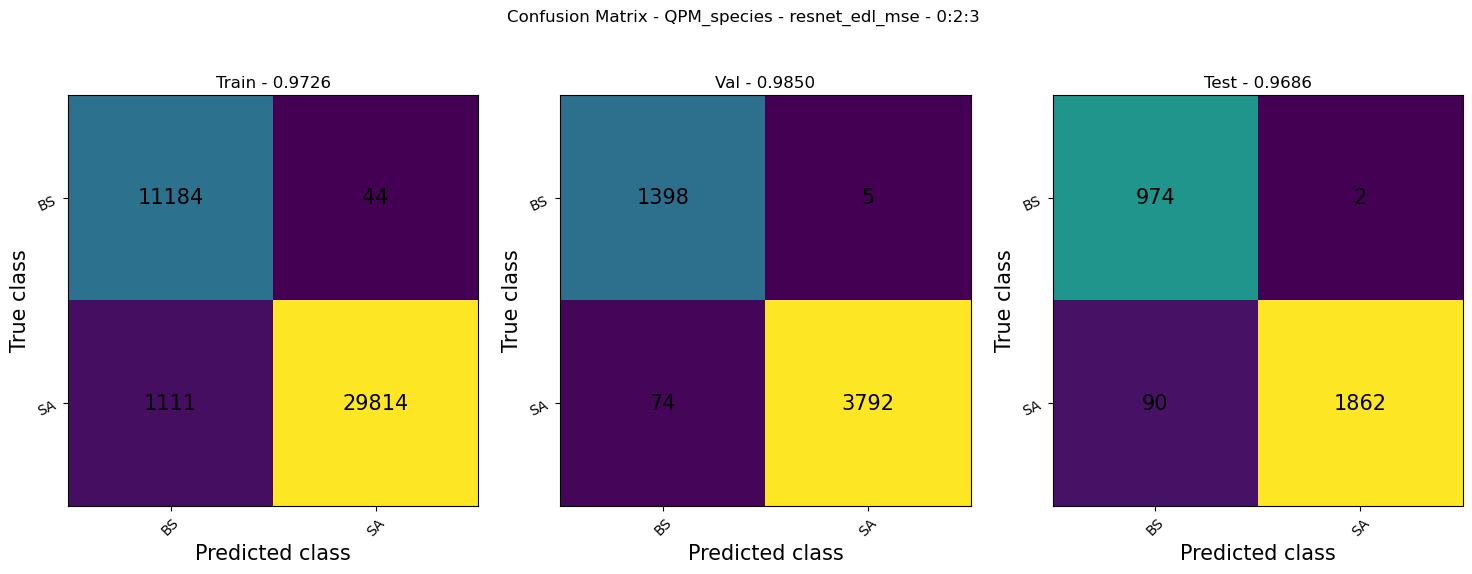

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(train_acc=train_acc, val_acc=val_acc, test_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

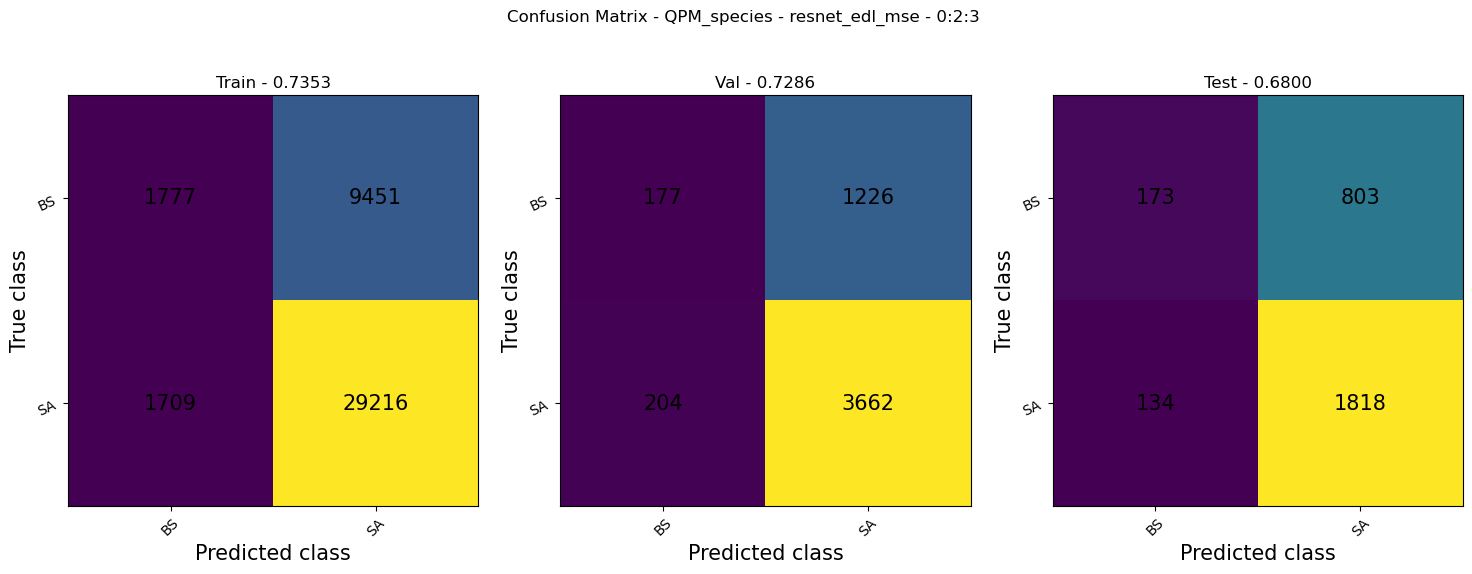

In [12]:
# compute test set accuracy - FPI
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()
run_stats.update(dict(ftrain_acc=train_acc, fval_acc=val_acc, ftest_acc=test_acc))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [13]:
# create 2d embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb2d = umap.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    lgt2d = umap.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


In [14]:
# create 2d embeddings - FPI
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(2928, 2) (17568, 2)
(2928, 2) (17568, 2)


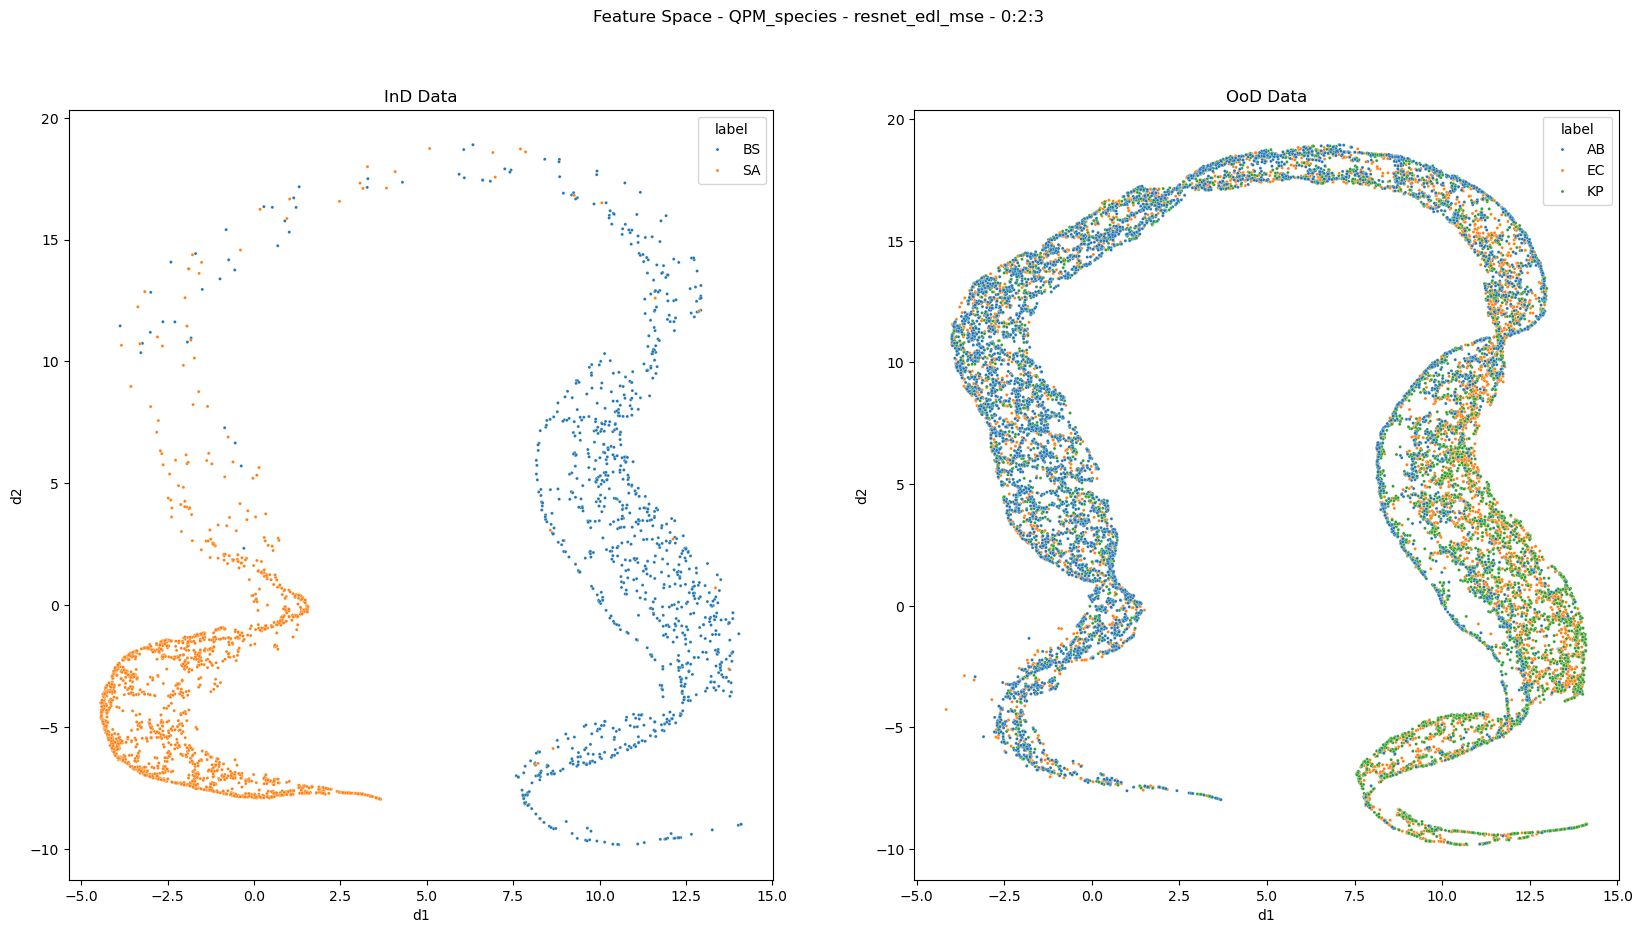

In [15]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

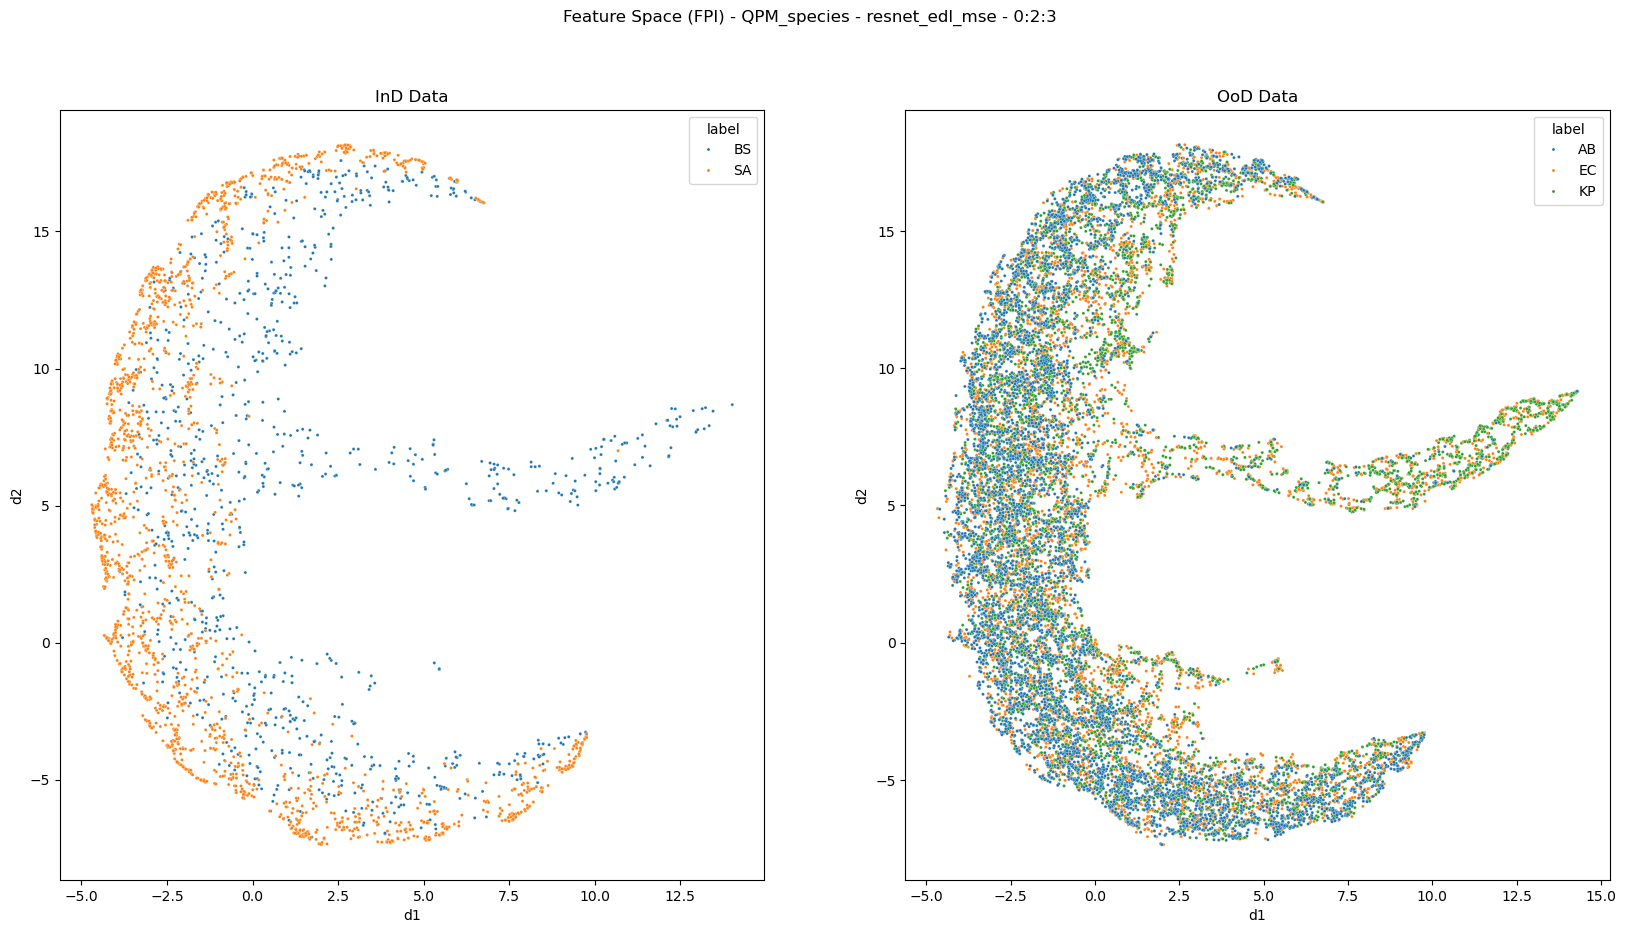

In [16]:
# plot feature space - FPI
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

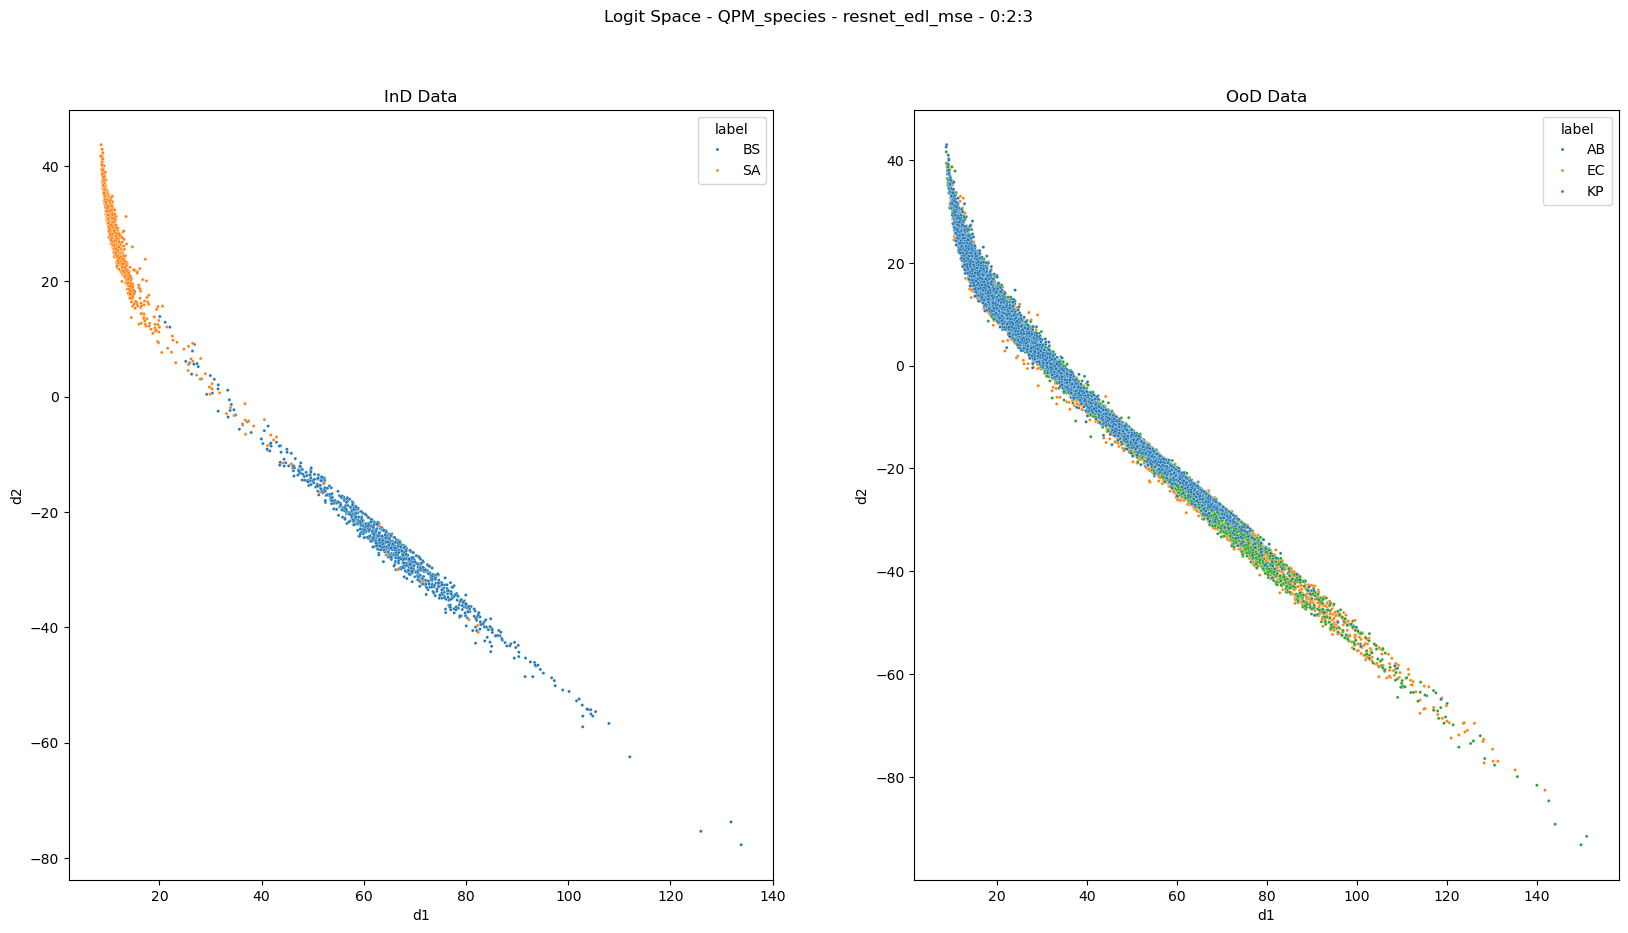

In [17]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

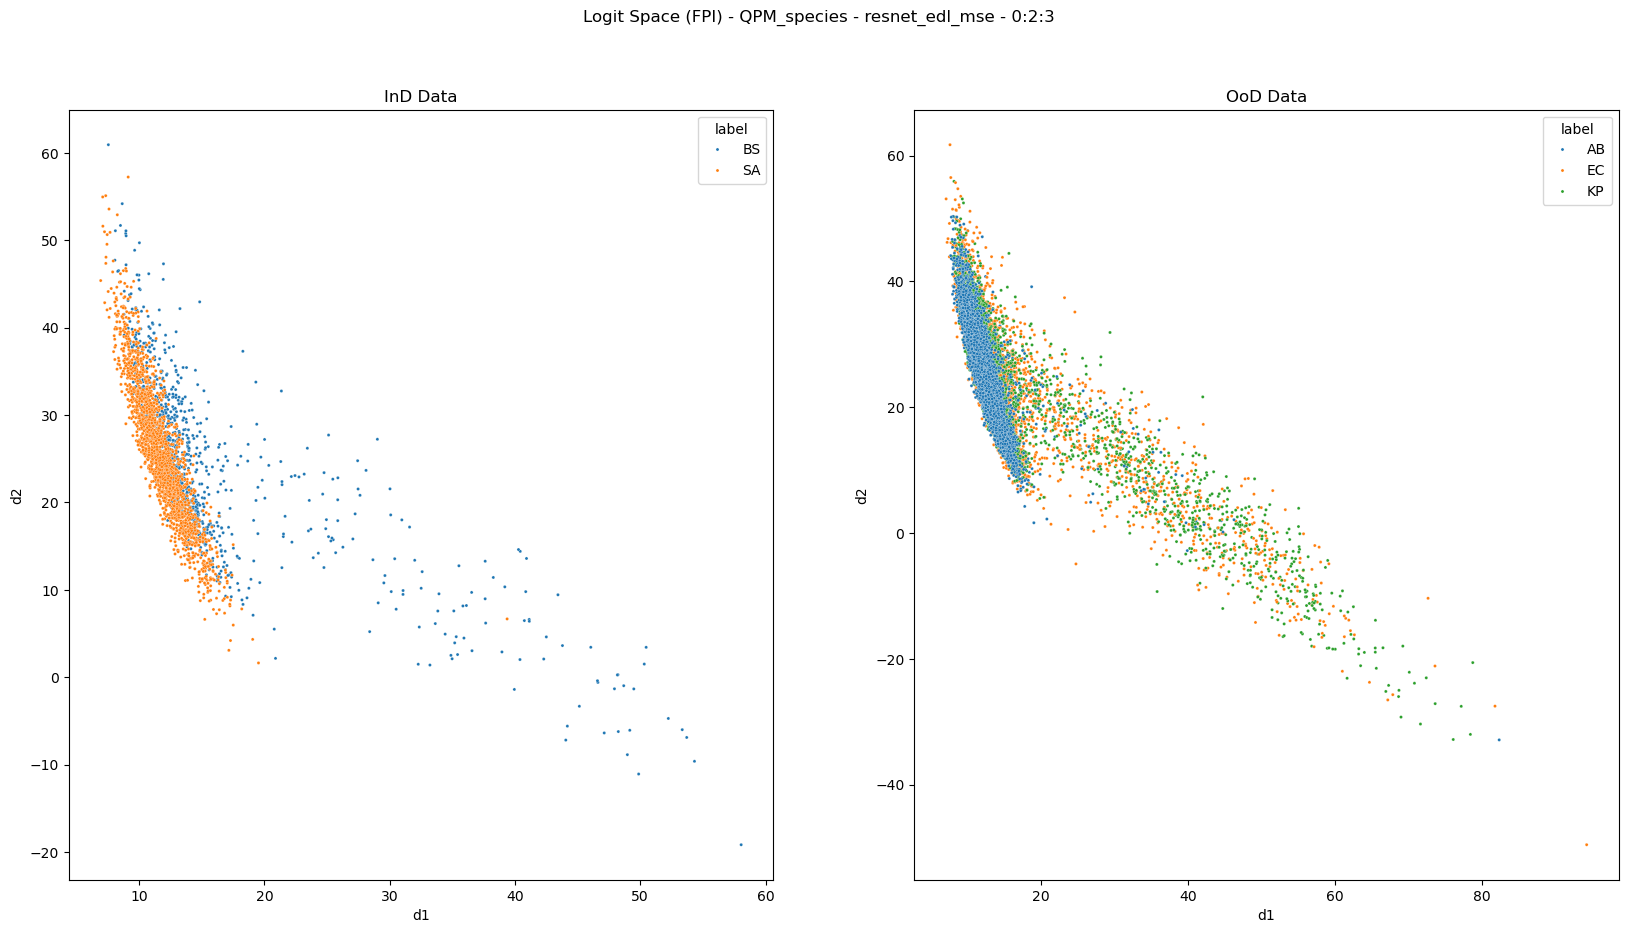

In [18]:
# plot logit space - FPI
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

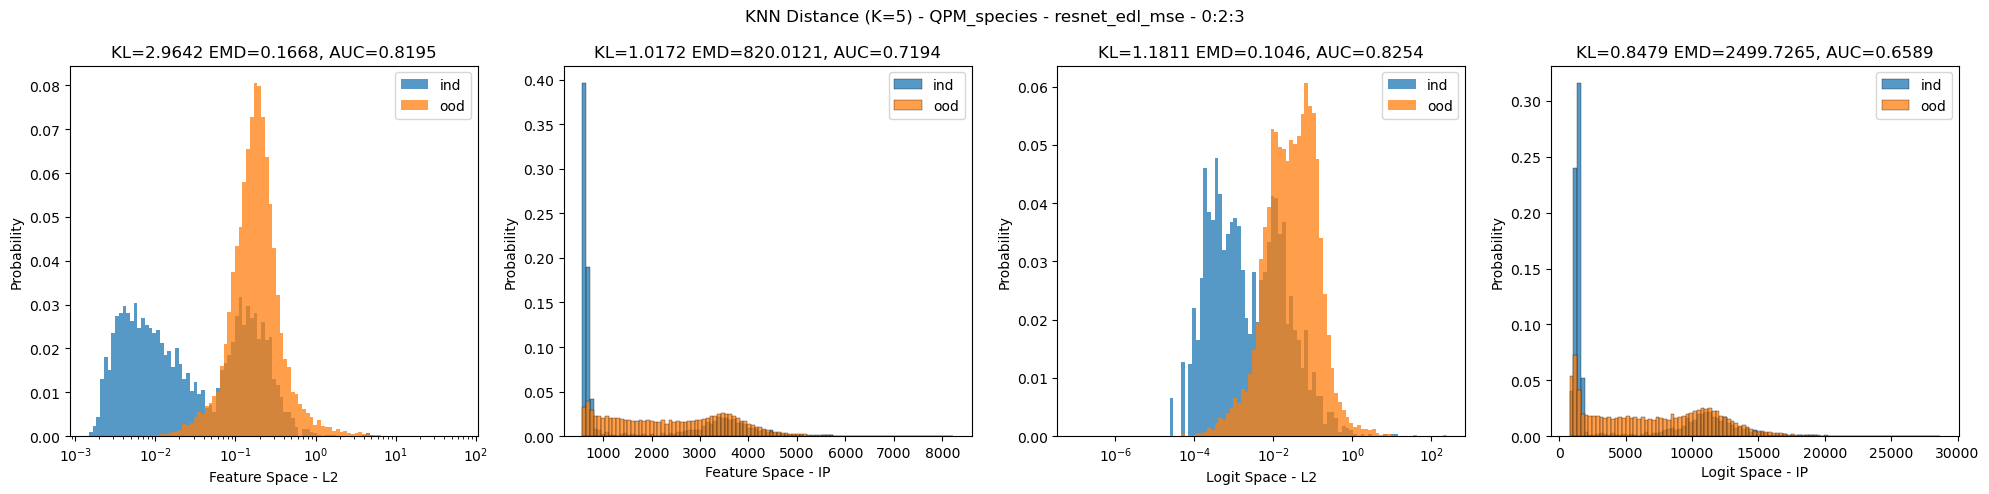

In [19]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats


fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_f_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="logspace")
axs[0].set_xlabel("Feature Space - L2")
run_stats["knn_f_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_emb, val_emb, ind_emb, ood_emb if ood_str else None, scale="linspace")
axs[1].set_xlabel("Feature Space - IP")
run_stats["knn_l_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="logspace")
axs[2].set_xlabel("Logit Space - L2")
run_stats["knn_l_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_lgt, val_lgt, ind_lgt, ood_lgt if ood_str else None, scale="linspace")
axs[3].set_xlabel("Logit Space - IP")
plt.tight_layout()
plt.show()

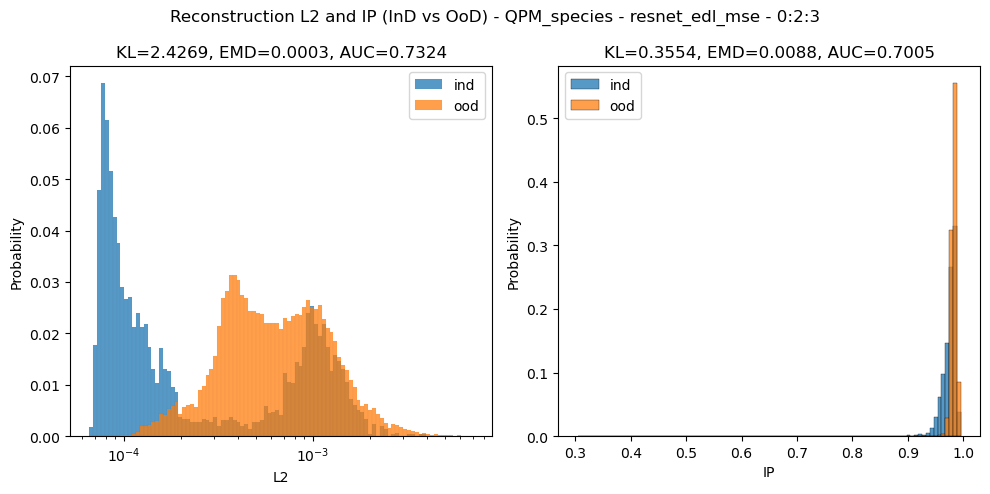

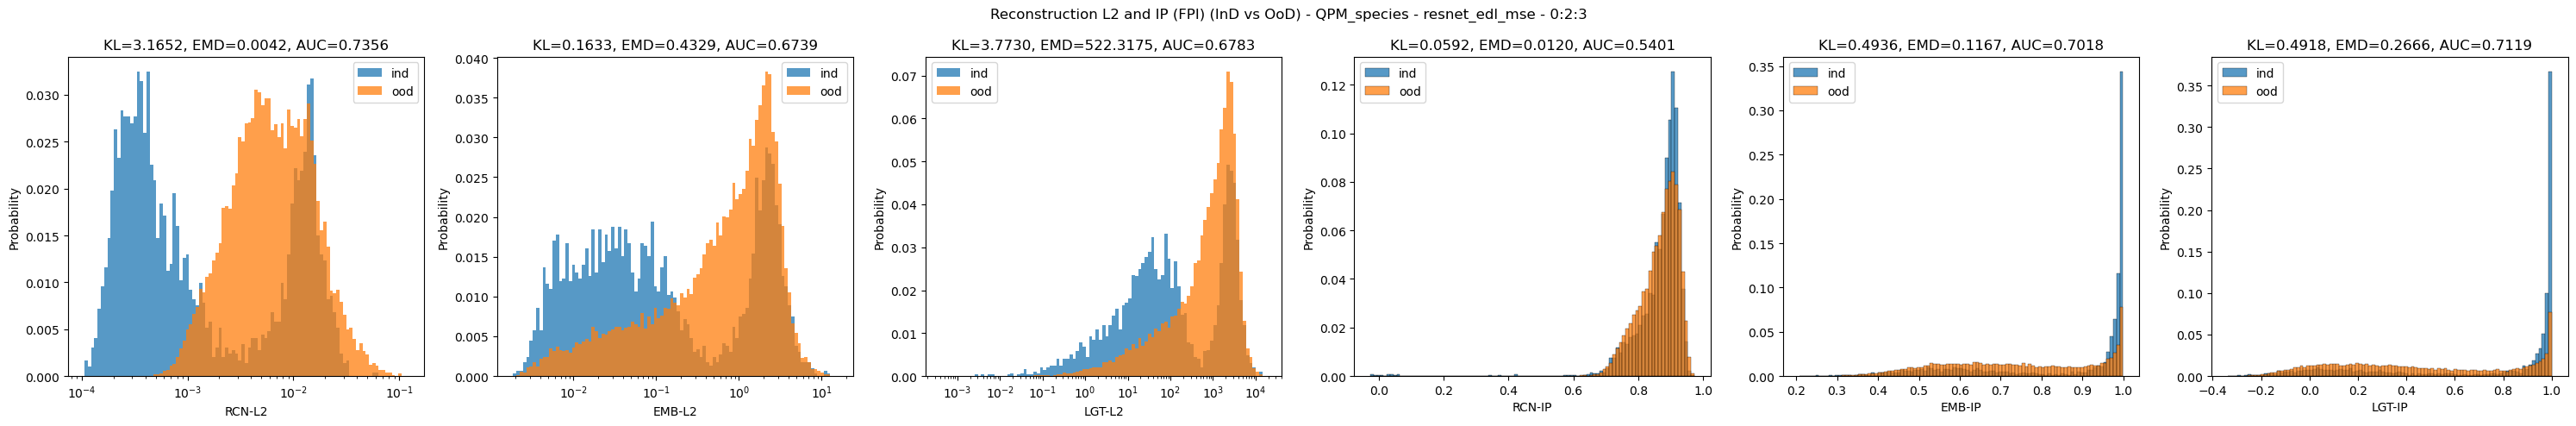

In [20]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# validation data
_val_inp = flatten(val_inp)
_val_rcn, _val_emb, _val_lgt = flatten(val_rcn), flatten(val_emb), flatten(val_lgt)
_val_rcn_fpi, _val_emb_fpi, _val_lgt_fpi = flatten(val_rcn_fpi), flatten(val_emb_fpi), flatten(val_lgt_fpi)
_val_inp_unit = unit(_val_inp)
_val_rcn_unit, _val_emb_unit, _val_lgt_unit = unit(_val_rcn), unit(_val_emb), unit(_val_lgt)
_val_rcn_fpi_unit, _val_emb_fpi_unit, _val_lgt_fpi_unit = unit(_val_rcn_fpi), unit(_val_emb_fpi), unit(_val_lgt_fpi)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)
val_rcn_l2_fpi = ((_val_inp - _val_rcn_fpi) ** 2).mean(-1)
val_emb_l2_fpi = ((_val_emb - _val_emb_fpi) ** 2).mean(-1)
val_lgt_l2_fpi = ((_val_lgt - _val_lgt_fpi) ** 2).mean(-1)
val_rcn_ip_fpi = (_val_inp_unit * _val_rcn_fpi_unit).sum(-1)
val_emb_ip_fpi = (_val_emb_unit * _val_emb_fpi_unit).sum(-1)
val_lgt_ip_fpi = (_val_lgt_unit * _val_lgt_fpi_unit).sum(-1)

# ind test data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # ood test data    
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()


fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))
run_stats["frcn_l2"] = plot_rcn(val_rcn_l2_fpi, ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
run_stats["femb_l2"] = plot_rcn(val_emb_l2_fpi, ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
run_stats["flgt_l2"] = plot_rcn(val_lgt_l2_fpi, ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
run_stats["frcn_ip"] = plot_rcn(val_rcn_ip_fpi, ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
run_stats["femb_ip"] = plot_rcn(val_emb_ip_fpi, ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
run_stats["flgt_ip"] = plot_rcn(val_lgt_ip_fpi, ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

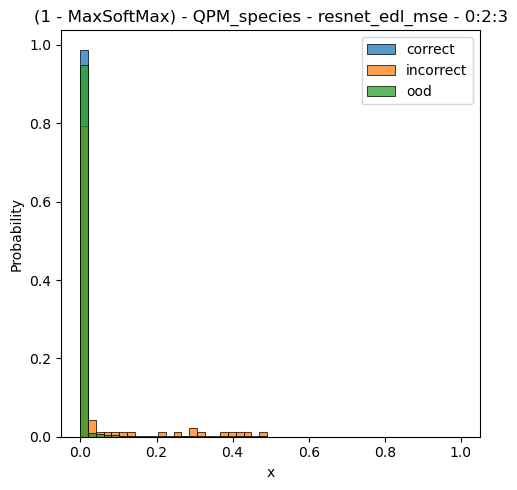

In [21]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

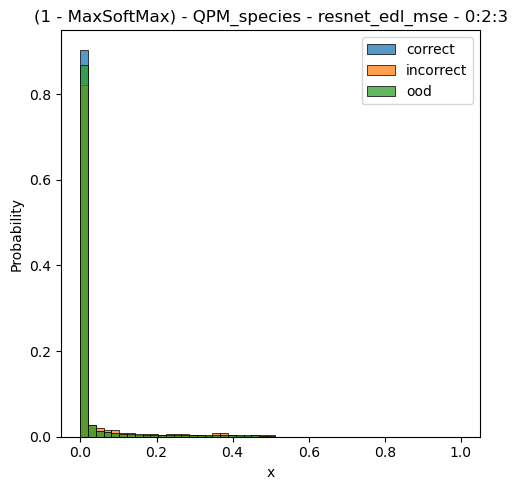

In [22]:
# plot (1 - maxsoftmax) distribution - FPI
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

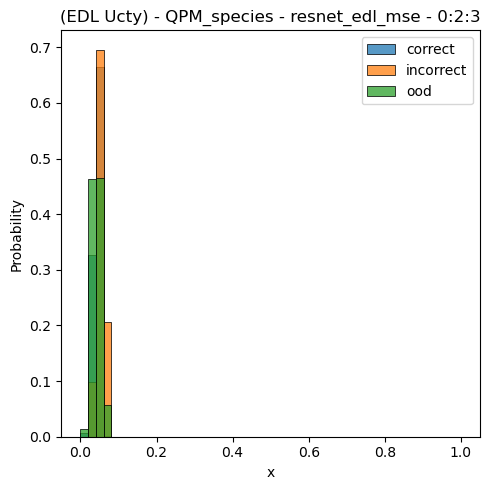

In [23]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt.shape[-1]
ind_belief = np.clip(ind_lgt, 0, None)
ind_pred = ind_lgt.argmax(-1)
ind_prob = ind_belief / (ind_belief.sum(-1, keepdims=True) + K)
ind_ucty = K / (ind_belief.sum(-1) + K)

if ood_str:
    ood_belief = np.clip(ood_lgt, 0, None)
    ood_pred = ood_lgt.argmax(-1)
    ood_prob = ood_belief / (ood_belief.sum(-1, keepdims=True) + K)
    ood_ucty = K / (ood_belief.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

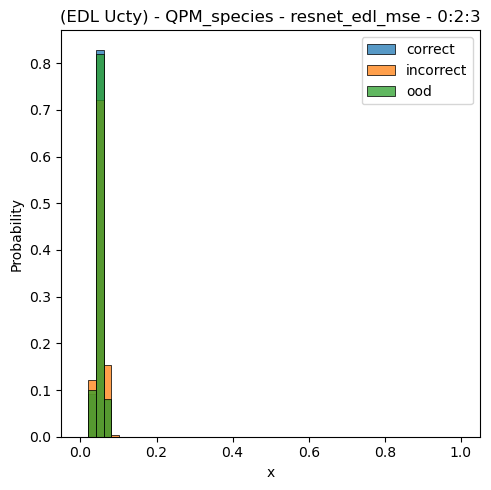

In [24]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data - FPI
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [25]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)